In [1]:
import numpy as np
import seaborn as sns
import hypertools as hyp
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from itertools import combinations, permutations
from collections import defaultdict
from scipy.stats import ttest_rel as ttest
from multiprocessing import Pool
import random


%load_ext line_profiler
%matplotlib inline

In [222]:
def get_hinges(k, n):
    return [tuple([0]+list(c)+[n-1]) for c in combinations(range(1, n-1), k)]

def sq_dist_to_point(line, point):
    n = line[1] - line[0]
    pa = line[0] - point
    
    c = np.dot(n, pa)
    
    #closest point is a
    if c > 0:
        return np.dot(pa, pa)
    
    pb = point - line[1]
    
    #closest point is b
    if np.dot(n, pb) > 0:
        return np.dot(pb, pb)
    
    #closest point is between a and b
    e = pa - np.multiply(n, np.divide(c, np.dot(n, n)))
    return np.dot(e, e)
    
def get_dists(segs, points):
    dist_dict = defaultdict()
    for p in points:
        dist_dict[tuple(p)] = defaultdict()
        for c in combinations(range(segs.shape[0]), 2):
                dist_dict[tuple(p)][c] = sq_dist_to_point([segs[c[0], :], segs[c[1], :]], p)
    return dist_dict

def get_distarr(segs, subj_data):
    combs = list(combinations(range(segs.shape[0]), 2))
    combdict = {j:i for i, j in enumerate(combs)}
    distarr = np.array([np.empty((s.shape[0], len(combs))) for s in subj_data])
    for i, sub in enumerate(subj_data):
        for j, p in enumerate(sub):
            for k, c in enumerate(combs):
                distarr[i][j, k] = sq_dist_to_point([segs[c[0], :], segs[c[1], :]], p)
    return distarr, combdict

def get_distarr_stacked(segs, points):
    combs = list(combinations(range(segs.shape[0]), 2))
    combdict = {j:i for i, j in enumerate(combs)}
    distarr = np.empty((points.shape[0], len(combs)))
    for i, p in enumerate(points):
        for j, c in enumerate(combs):
                distarr[i, j] = sq_dist_to_point([segs[c[0], :], segs[c[1], :]], p)
    return distarr, combdict


def run_perm(subj_data, distdict, k=10, test_size=.5, random_state=None):
    res=[]
    n=34
    if random_state is None:
        random_state = np.random.seed()
    training_data, test_data = train_test_split(subj_data, test_size=test_size, random_state=random_state)
    
    # train model
    for k in range(1, k+1):
        stacked_data = np.vstack(training_data)
        best_dist = np.inf
        hingerator = combinations(range(1, n), k)
        done=False
        for h in hingerator:
            while (np.diff([0]+list(h)+[n-1])<=2).any():
                try:
                    h = next(hingerator)
                except StopIteration:
                    done=True
                    break
            if not done:
                h = [0]+list(h)+[n-1]
                dist = np.empty(len(stacked_data))
                for j, p in enumerate(stacked_data):
                    dist[j] = min([distdict[tuple(p)][(h[i], h[i+1])] for i in range(len(h)-1)])
                next_dist = np.mean(dist)
                if next_dist < best_dist:
                    best_dist = next_dist
                    best_hinge = h

        # get test error
        stacked_data = np.vstack(test_data)
        dist = np.empty(len(stacked_data))
        for j, p in enumerate(stacked_data):
            dist[j] = min([distdict[tuple(p)][(best_hinge[i], best_hinge[i+1])] for i in range(len(best_hinge)-1)])
        test_error = np.mean(dist)

        r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': best_hinge, 'perm': random_state}
        res.append(r)
        print(r)
        
    return res

def run_perm_par(subj_data, distarr, combdict, k=10, test_size=.5, random_state=None):
    import multiprocess
    def run_k(k):
        
        # search for optimal hinges, skipping every 2
        stacked_data = np.vstack(training_data)
        best_dist = np.inf
        hingerator = combinations(range(1, n), k)
        done=False
        for h in hingerator:
            while (np.diff([0]+list(h)+[n-1])<=1).any():
                try:
                    h = next(hingerator)
                except StopIteration:
                    done=True
                    break
            if not done:
                h = [0]+list(h)+[n-1]
                dist = np.empty(len(stacked_data))
                for j, p in enumerate(stacked_data):
                    inds = np.array([combdict[tuple([h[i], h[i+1]])] for i in range(len(h)-1)])
                    dist[j] = distarr[j, inds].min()
                next_dist = np.mean(dist)
                if next_dist < best_dist:
                    best_dist = next_dist
                    best_hinges = h
        
#         # optimize the hinge placement by jiggling them around
#         opt_hinges = np.zeros_like(best_hinges, dtype=np.int)
#         while not np.allclose(opt_hinges, best_hinges):
#             #for every triplet of hinges, optimize the middle point (and use it moving forward)
#             opt_hinges = np.copy(best_hinges).astype(np.int)
#             for i in np.arange(len(best_hinges)-2):
#                 next_inds = np.arange(int(best_hinges[i])+1, int(best_hinges[i+2])) #possible positions for next hinge are bounded by neighbors      
#                 best_mse = np.inf
#                 best_ind = -1
#                 for j in next_inds:
#                     next_ind = next_inds[0]
#                     # next_mse = get_hinge(all_data, all_labels, replace_hinge(data, best_hinges, i+1, next_ind))
#                     if next_mse < best_mse:
#                         best_mse = next_mse
#                         best_ind = j
#                 if best_ind != -1:
#                     best_hinges[i+1] = best_ind

        # get test error
        stacked_data = np.vstack(test_data)
        dist = np.empty(len(stacked_data))
        for j, p in enumerate(stacked_data):
            inds = np.array([combdict[tuple([best_hinges[i], best_hinges[i+1]])] for i in range(len(best_hinges)-1)])
            dist[j] = distarr[j, inds].min()
        test_error = np.mean(dist)
        return {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': best_hinges, 'perm': random_state}
        
    res=[]
    n=34
    if random_state is None:
        random_state = np.random.seed()
    training_data, test_data = train_test_split(subj_data, test_size=test_size, random_state=random_state)
    pool = multiprocess.Pool(multiprocess.cpu_count())
    res = pool.map(run_k, range(1, k+1))
    return res

In [216]:
def run_perm_arr(subj_data, distarr, combdist, k=10, test_size=.5, random_state=None):
    res=[]
    n=34
    if random_state is None:
        random_state = np.random.seed()
    training_data, test_data = train_test_split(pd.DataFrame(subj_data), test_size=test_size, random_state=random_state)
    training_inds, test_inds = training_data.index, test_data.index
    
    # train model
    for k in range(1, k+1):
        best_dist = np.inf
        hingerator = combinations(range(1, n-1), k)
        done=False
        for h in hingerator:
            while (np.diff([0]+list(h)+[n-1])<=1).any():
                try:
                    h = next(hingerator)
                except StopIteration:
                    done=True
                    break
            if not done:
                h = [0]+list(h)+[n-1]
                hinge_inds = np.array([combdict[tuple([h[i], h[i+1]])] for i in range(len(h)-1)])
                next_dist = np.mean([s[:, hinge_inds].min(1).mean() for s in distarr[training_inds]])
                if next_dist < best_dist:
                    best_dist = next_dist
                    hinges = h
        
        # test model
        hinge_inds = np.array([combdict[tuple([hinges[i], hinges[i+1]])] for i in range(len(hinges)-1)])
        test_error = np.mean([s[:, hinge_inds].min(1).mean() for s in distarr[test_inds]])

        r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': hinges, 'perm': random_state}
        res.append(r)
        print(r)
        
    return res

In [244]:
def run_perm_arr_opt(subj_data, distarr, combdist, subj_inds, k=10, test_size=.5, random_state=None):
    res=[]
    n=34
    if random_state is None:
        random_state = np.random.seed()
    training_data, test_data = train_test_split(pd.DataFrame(subj_data), test_size=test_size, random_state=random_state)
    training_inds, test_inds = training_data.index, test_data.index
    training_inds = np.hstack(subj_inds[training_inds])
    test_inds = np.hstack(subj_inds[test_inds])
    
    # train model
    for k in range(1, k+1):
        best_dist = np.inf
        hingerator = combinations(range(1, n-1), k)
        done=False
        for h in hingerator:
            while (np.diff([0]+list(h)+[n-1])<=1).any():
                try:
                    h = next(hingerator)
                except StopIteration:
                    done=True
                    break
            if not done:
                h = [0]+list(h)+[n-1]
                hinge_inds = np.array([combdict[tuple([h[i], h[i+1]])] for i in range(len(h)-1)])
                next_dist = np.mean(distarr[training_inds, :][:, hinge_inds].min(1))
                if next_dist < best_dist:
                    best_dist = next_dist
                    hinges = h
        
        # test model
        hinge_inds = np.array([combdict[tuple([hinges[i], hinges[i+1]])] for i in range(len(hinges)-1)])
        test_error = np.mean(distarr[test_inds, :][:, hinge_inds].min(1))

        r = {'k': k, 'training_error': best_dist, 'test_error': test_error, 'hinges': hinges, 'perm': random_state}
        res.append(r)
        print(r)
        
    return res

## Load data

In [3]:
video_events, subj_data = np.load('../data/events.npy')
subj_data = np.array(subj_data)

## Find distances between all lines and points

In [247]:
distdict = get_dists(video_events, np.vstack(subj_data))
distarr, combdict = get_distarr(video_events, subj_data)

In [249]:
distarr, combdict = get_distarr_stacked(video_events, np.vstack(subj_data))
subj_inds = np.array([np.empty(s.shape[0]).astype(int) for s in subj_data])
count = -1
for i, sub in enumerate(subj_data):
    for j in range(sub.shape[0]):
        count+=1
        subj_inds[i][j]=count

In [250]:
%%prun
nperms = 1
perms=[]
for perm in range(nperms):
    perms.append(run_perm_arr_opt(subj_data, distarr, combdict, subj_inds, random_state=perm, k=3))

{'k': 1, 'training_error': 0.34989988199705424, 'test_error': 0.36654400376454616, 'hinges': [0, 27, 33], 'perm': 0}
{'k': 2, 'training_error': 0.27635993212776333, 'test_error': 0.271059471080913, 'hinges': [0, 13, 27, 33], 'perm': 0}
{'k': 3, 'training_error': 0.25296184294577734, 'test_error': 0.24649406287622336, 'hinges': [0, 8, 13, 27, 33], 'perm': 0}
 

## Run analysis

In [248]:
%%prun
nperms = 1
perms=[]
for perm in range(nperms):
    perms.append(run_perm_arr(subj_data, distarr, combdict, random_state=perm, k=3))

{'k': 1, 'training_error': 0.34660412906165505, 'test_error': 0.34739820487406803, 'hinges': [0, 2, 33], 'perm': 0}
{'k': 2, 'training_error': 0.27376321878560395, 'test_error': 0.2719987901927671, 'hinges': [0, 13, 27, 33], 'perm': 0}
{'k': 3, 'training_error': 0.2482380172256664, 'test_error': 0.247780239547006, 'hinges': [0, 8, 13, 27, 33], 'perm': 0}
 

In [141]:
%%prun
nperms = 1
perms=[]
for perm in range(nperms):
    perms.append(run_perm(subj_data, distdict, random_state=perm, k=5))

{'k': 1, 'training_error': 0.34989988199705424, 'test_error': 0.36654400376454616, 'hinges': [0, 27, 33], 'perm': 0}
{'k': 2, 'training_error': 0.27635993212776333, 'test_error': 0.271059471080913, 'hinges': [0, 13, 27, 33], 'perm': 0}


KeyboardInterrupt: 

In [32]:
%%prun
nperms = 1
perms=[]
for perm in range(nperms):
    perms.append(run_perm_par(subj_data, distarr, combdict, random_state=perm, k=4))

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/queues.py", line 346, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/site-packag

## Test importance of line segment

In [91]:
hinges = np.array([0, 4, 7, 10, 13, 16, 19, 23, 26, 29, 33])
line_segments = [(hinges[i], hinges[i+1]) for i in range(len(hinges)-1)]
video_model, recall_models = np.load('../data/events.npy')
hinge_model = video_model[hinges,:]
inds = np.array(list(range(len(line_segments))))
mses_all = np.empty((len(recall_models), 1))

for j, r in enumerate(recall_models):
    points = []
    for p in r:
        points.append(min([distdict[tuple(p)][l] for l in line_segments]))
    mses_all[j] = np.mean(points)


mses = np.empty((len(inds), len(recall_models)))
for i in inds:
    m = [l for li, l in enumerate(line_segments) if li!=i]
    for j, r in enumerate(recall_models):
        points = []
        for p in r:
            points.append(min([distdict[tuple(p)][l] for l in m]))
        mses[i, j] = np.mean(points)

segment_importance = ttest(mses.T, mses_all).statistic
np.save('../data/segment_importance', segment_importance)

## For each point, find the closest line segment

In [10]:
hinges = np.array([0, 4, 7, 10, 13, 16, 19, 23, 26, 29, 33])
line_segments = [(hinges[i], hinges[i+1]) for i in range(len(hinges)-1)]
video_model, recall_models = np.load('../data/events.npy')
closest_lines = []
for j, r in enumerate(recall_models):
    points = []
    for p in r:
        points.append(np.argmin([distdict[tuple(p)][l] for l in line_segments]))
    closest_lines.append(points)
np.save('../data/closest_lines', closest_lines)

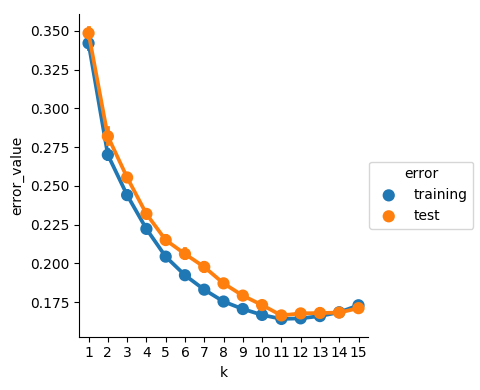

In [258]:
import pandas as pd
import os
sns.reset_defaults()
ds = []
for n in os.listdir('../data/segment/skip1/'):
    ds.append(pd.DataFrame(list(np.load('../data/segment/skip1/%s' % n))))
df = pd.concat(ds)
training2 = df.copy()
training2['error']='training'
training2 = training2.drop('test_error', 1)
training2 = training2.rename(columns={'training_error':'error_value'})
test2 = df.copy()
test2['error']='test'
test2 = test2.drop('training_error', 1)
test2 = test2.rename(columns={'test_error':'error_value'})
df = pd.concat([training2, test2])
sns.factorplot(data=df, x='k', y='error_value', hue='error')
plt.show()

In [266]:
df[df['k']==11]
hinges = [0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]

,hinges,k,perm,error_value,error
10,"[0, 2, 5, 8, 10, 13, 17, 19, 22, 24, 27, 31, 33]",11,1,0.162357,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 22, 24, 27, 31, 33]",11,10,0.166758,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 24, 27, 31, 33]",11,11,0.161698,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]",11,12,0.163050,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]",11,13,0.161403,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]",11,14,0.160053,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 22, 24, 27, 31, 33]",11,15,0.162020,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 24, 27, 31, 33]",11,16,0.166686,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]",11,17,0.168395,training
10,"[0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]",11,18,0.166037,training
